In [1]:
import pandas as pd
import numpy as np
import torch
import time
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

### Variable Initializations

In [9]:
with open('data.txt') as f:
    txt = f.read()

txt_lis = txt.split('\n')
data = [i.split() for i in txt_lis]

In [120]:
voc = ''
X = []
y = []

for i in data:
    if i:
        X.append(i[0])
        y.append(i[1])
        voc += i[0]+i[1]
voc = list(set(voc))

voc_dic = {item:idx+1 for idx, item in enumerate(voc)}
voc_dic['<start>'] = len(voc)+1

### Train Test Split

In [121]:
X_id = [[voc_dic[j] for j in i] for i in X]
y_id = [[voc_dic[j] for j in i] for i in y]

X_max_len = max([len(i) for i in X_id])
y_max_len = max([len(i) for i in y_id])

X_train, X_test, y_train, y_test = train_test_split(X_id, y_id, test_size=0.2, shuffle=True)

In [122]:
class dataset_(Dataset):
    
    def __init__(self, X, y):
        super(dataset_, self).__init__()
        pad_X = [[0]*(X_max_len-len(i[:X_max_len]))+i[:X_max_len] for i in X]
        pad_y = [i[:y_max_len]+[0]*(y_max_len-len(i[:y_max_len])) for i in y]
        self.X = torch.tensor(np.array(pad_X), dtype=torch.int32)
        self.y = torch.tensor(np.array(pad_y), dtype=torch.long)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
train_ = dataset_(X_train, y_train)
test_ = dataset_(X_test, y_test)

# seq = nn.utils.rnn.pack_padded_sequence(train_.X, train_.X.bool().sum(1), batch_first=True, enforce_sorted=False)

### Naive RNN

In [210]:
class naive(nn.Module):
    
    def __init__(self, n_layers):
        super(naive, self).__init__()
        
        self.emb = nn.Embedding(len(voc_dic)+1, 10, 0) 
        self.encoder = nn.RNN(10, 10, n_layers, batch_first=True)     
        self.decoder = nn.RNN(10, 10, n_layers, batch_first=True)
        
        self.final = nn.Linear(10, len(voc_dic))
        
    def forward(self, x):
        
        x = self.emb(x)  
        _, h = self.encoder(x)
        
        out = []
        x0 = self.emb(torch.Tensor([[voc_dic['<start>']]]*h.shape[1]).cuda().int())
        for i in range(y_max_len):
            x0, h = self.decoder(x0, h)
            out.append(x0)
        
        out = torch.cat(out, dim=1)
        out = self.final(out)
        
        return out.transpose(-2,-1)

In [211]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0005, epochs=20, batch_size=32, verbose=1):
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = model.to(device)
    op = torch.optim.Adam(model.parameters(), lr=lr)
    Loss = nn.CrossEntropyLoss().to(device)
    
    print('Training start!')
    start = time.time()

    for epoch in range(epochs):

        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            loss = Loss(out, y)
            acc = (out.argmax(-2)==y).float().mean()

            op.zero_grad()
            loss.backward()
            op.step()

            train_loss += loss
            train_acc += acc

        model.eval()
        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X)
                loss = Loss(out, y)
                acc = (out.argmax(-2)==y).float().mean()
                test_loss += loss
                test_acc += acc

        train_loss = (train_loss/len(train_loader)).item()
        test_loss = (test_loss/len(test_loader)).item()
        train_acc = (train_acc/len(train_loader)).item()
        test_acc = (test_acc/len(test_loader)).item()

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)   
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)  

        if not (epoch+1)%10 and verbose:
            print(f'Epoch: {epoch+1}/{epochs}')
            print(f'Train Loss: {format(train_loss, ".8f")}\t\tTrain Accuracy: {format(train_acc*100, ".4f")}%')
            print(f'Test Loss: {format(test_loss, ".8f")}\t\tTest Accuracy: {format(test_acc*100, ".4f")}%')

    print(f'\nTraining complete! Spent time: {format(time.time()-start, ".5f")} seconds\n')
    
    return history

In [212]:
ez = naive(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 7e-3
epochs = 500
batch_size = 128
hist_0 = train_model(ez, train_, test_, device, lr, epochs, batch_size)

Training start!
Epoch: 10/500
Train Loss: 1.41169441		Train Accuracy: 59.6936%
Test Loss: 1.41745067		Test Accuracy: 60.1830%
Epoch: 20/500
Train Loss: 1.11509264		Train Accuracy: 66.2806%
Test Loss: 1.08056271		Test Accuracy: 64.9327%
Epoch: 30/500
Train Loss: 1.02535033		Train Accuracy: 68.6982%
Test Loss: 1.02056313		Test Accuracy: 68.9657%
Epoch: 40/500
Train Loss: 0.99391717		Train Accuracy: 69.2022%
Test Loss: 0.94923180		Test Accuracy: 70.9177%
Epoch: 50/500
Train Loss: 0.96334118		Train Accuracy: 70.1888%
Test Loss: 0.95990276		Test Accuracy: 70.3436%
Epoch: 60/500
Train Loss: 0.94838732		Train Accuracy: 70.4589%
Test Loss: 0.93821460		Test Accuracy: 70.5614%
Epoch: 70/500
Train Loss: 1.00921595		Train Accuracy: 68.7338%
Test Loss: 0.92739952		Test Accuracy: 71.2443%
Epoch: 80/500
Train Loss: 0.99935603		Train Accuracy: 69.1532%
Test Loss: 0.93051428		Test Accuracy: 71.2522%
Epoch: 90/500
Train Loss: 0.97285050		Train Accuracy: 69.7928%
Test Loss: 0.91491449		Test Accuracy: 71.

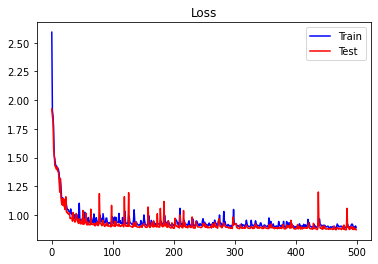

In [213]:
plt.title('Loss')
plt.plot(hist_0['train_loss'], label='Train', color='b')
plt.plot(hist_0['test_loss'], label='Test', color='r')
plt.legend();

### Answer for Q4 & Q5: LSTM

In [186]:
## If the input sentence is too long, a naive RNN might suffer from gradient explosion and vanishing, fading its memories.
## A good way to prevent this is the gate mechanism, where we can use LSTM or GRU for improvements.
## But that can neither save the model when the sentence gets extremely long.
## In this case, we would use Attention mechanism.
## Here for a baseline, we just use LSTM for basic improvements.

class seq2seq(nn.Module):
    
    def __init__(self, n_layers):
        super(seq2seq, self).__init__()
        
        self.emb = nn.Embedding(len(voc_dic)+1, 10, 0) 
        self.encoder = nn.LSTM(10, 10, n_layers, batch_first=True)     
        self.decoder = nn.LSTM(10, 10, n_layers, batch_first=True)
        
        self.final = nn.Linear(10, len(voc_dic))
        
    def forward(self, x):
        
        x = self.emb(x)  
        _, (h, c) = self.encoder(x)
        
        out = []
        x0 = self.emb(torch.Tensor([[voc_dic['<start>']]]*h.shape[1]).cuda().int())
        for i in range(y_max_len):
            x0, (h,c) = self.decoder(x0, (h, c))
            out.append(x0)
        
        out = torch.cat(out, dim=1)
        out = self.final(out)
        
        return out.transpose(-2,-1)

In [208]:
mod = seq2seq(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 7e-3
epochs = 500
batch_size = 128
hist = train_model(mod, train_, test_, device, lr, epochs, batch_size)

Training start!
Epoch: 10/500
Train Loss: 0.99621916		Train Accuracy: 71.3044%
Test Loss: 0.96249706		Test Accuracy: 72.6043%
Epoch: 20/500
Train Loss: 0.82322198		Train Accuracy: 75.6340%
Test Loss: 0.79990530		Test Accuracy: 76.2837%
Epoch: 30/500
Train Loss: 0.72257000		Train Accuracy: 79.0050%
Test Loss: 0.70504206		Test Accuracy: 79.9191%
Epoch: 40/500
Train Loss: 0.64669198		Train Accuracy: 81.4275%
Test Loss: 0.64219487		Test Accuracy: 81.5215%
Epoch: 50/500
Train Loss: 0.60323662		Train Accuracy: 82.4379%
Test Loss: 0.59119511		Test Accuracy: 82.7603%
Epoch: 60/500
Train Loss: 0.57138371		Train Accuracy: 83.3157%
Test Loss: 0.56379849		Test Accuracy: 83.5662%
Epoch: 70/500
Train Loss: 0.54600757		Train Accuracy: 84.0120%
Test Loss: 0.54070246		Test Accuracy: 84.2981%
Epoch: 80/500
Train Loss: 0.52277976		Train Accuracy: 84.5745%
Test Loss: 0.51585084		Test Accuracy: 84.9347%
Epoch: 90/500
Train Loss: 0.53463072		Train Accuracy: 84.0648%
Test Loss: 0.50094473		Test Accuracy: 85.

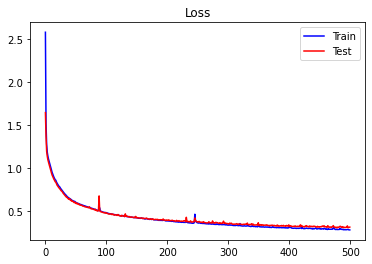

In [209]:
plt.title('Loss')
plt.plot(hist['train_loss'], label='Train', color='b')
plt.plot(hist['test_loss'], label='Test', color='r')
plt.legend();

### Answer for Q6: Attention

In [257]:
class att(nn.Module):
    
    def __init__(self, n_layers):
        super(att, self).__init__()
        
        self.emb = nn.Embedding(len(voc_dic)+1, 10, 0) 
        self.encoder = nn.LSTM(10, 10, n_layers, batch_first=True)     
        self.decoder = nn.LSTM(10, 10, n_layers, batch_first=True)
        self.transform = nn.Linear(20, 10)
        self.final = nn.Linear(10, len(voc_dic))
        
    def forward(self, x):
        
        x_emb = self.emb(x)  
        out_enc, (h, c) = self.encoder(x_emb)
        out_enc = out_enc*x.bool().unsqueeze(-1)
        
        out_dec = []
        x0 = self.emb(torch.Tensor([[voc_dic['<start>']]]*h.shape[1]).cuda().int())
        for i in range(y_max_len):
            score = x0.matmul(out_enc.transpose(-2,-1))
            out_att = nn.Softmax(-1)(score).matmul(out_enc)
            x0 = self.transform(torch.cat([x0, out_att], dim=-1))
            x0, (h,c) = self.decoder(x0, (h, c))
            out_dec.append(x0)
            
        out_dec = torch.cat(out_dec, dim=1)
        out = self.final(out_dec)
        
        return out.transpose(-2,-1)

In [258]:
mod = att(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 7e-3
epochs = 500
batch_size = 128
hist = train_model(mod, train_, test_, device, lr, epochs, batch_size)

Training start!
Epoch: 10/500
Train Loss: 0.98685765		Train Accuracy: 71.0679%
Test Loss: 0.95709914		Test Accuracy: 71.8413%
Epoch: 20/500
Train Loss: 0.89707851		Train Accuracy: 73.4387%
Test Loss: 0.87138128		Test Accuracy: 74.2308%
Epoch: 30/500
Train Loss: 0.82232600		Train Accuracy: 76.2836%
Test Loss: 0.79403758		Test Accuracy: 77.3088%
Epoch: 40/500
Train Loss: 0.73977697		Train Accuracy: 78.5705%
Test Loss: 0.71576959		Test Accuracy: 79.4110%
Epoch: 50/500
Train Loss: 0.67477375		Train Accuracy: 80.3425%
Test Loss: 0.65784883		Test Accuracy: 80.8080%
Epoch: 60/500
Train Loss: 0.62146962		Train Accuracy: 81.9380%
Test Loss: 0.60517621		Test Accuracy: 82.3708%
Epoch: 70/500
Train Loss: 0.58492720		Train Accuracy: 82.8132%
Test Loss: 0.57861805		Test Accuracy: 83.1306%
Epoch: 80/500
Train Loss: 0.55508691		Train Accuracy: 83.6155%
Test Loss: 0.54494625		Test Accuracy: 83.9926%
Epoch: 90/500
Train Loss: 0.53725582		Train Accuracy: 84.0922%
Test Loss: 0.53034192		Test Accuracy: 84.

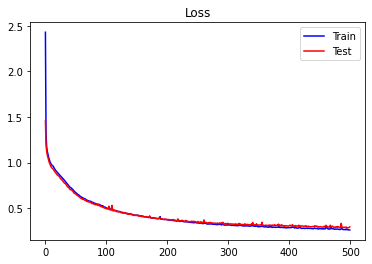

In [259]:
plt.title('Loss')
plt.plot(hist['train_loss'], label='Train', color='b')
plt.plot(hist['test_loss'], label='Test', color='r')
plt.legend();

#### Here we only apply an easy attention on the original LSTM model. Suprisingly, LSTM+Attention model only slightly outperforms LSTM, at the expense of over two times of the time complexity. This might be because the sequence length, about 20 in our case, is still okay for LSTM model to learn the data pattern. So LSTM+Attention, although more advanced, cannot fully demonstrate its advantage.